### Install Library

## Storyline Data Preprocessing

In [1]:
%pip install emoji textblob transformers sentencepiece langdetect fasttext-wheel numpy better-profanity emoji gensim pyLDAvis scipy bertopic sentence-transformers hdbscan umap-learn stanza
%pip install --upgrade gensim numpy scipy
!conda install gensim -y

# Restart kernel manually or add this to force reload
# import os
# os._exit(00)

Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.2.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
Note: you may need to restart the kernel to use updated packages.
Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



### Import Library

In [2]:
import pandas as pd
import emoji
import numpy as np
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

#Data Preprocessing and Feature Engineering
import re
import nltk
#from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

import stanza
from better_profanity import profanity

import fasttext
import torch
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer, AutoTokenizer, AutoModelForSequenceClassification, AutoModel, pipeline

from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\babym\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\babym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\babym\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\babym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\babym\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\babym\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

### Constant

In [ ]:
filename = 'ao3_books_fandom_stories.csv'
output_filename = 'ao3_books_fandom_stories_output.csv'
vis_output = 'lda_visualization_storyline_ao3.html'
vis_output_bert = 'lda_visualization_storyline_ao3_bert.html'
num_topics = 50
num_words=10

# Load fastText language ID model
lang_model = fasttext.load_model('lid.176.bin')

# Load M2M100 model & tokenizer for translator
model_name = "facebook/m2m100_418M"
tokenizer = M2M100Tokenizer.from_pretrained(model_name)
model = M2M100ForConditionalGeneration.from_pretrained(model_name)

stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()

# Load Stanza model for English
stanza.download("en")
nlp = stanza.Pipeline(lang="en", processors="tokenize,pos,lemma")

# Add custom stop words for generic nouns
custom_stop_words = set(["thing", "stuff", "person", "people"])
auxiliary_verbs = {'be', 'have', 'do', 'will', 'shall', 'would', 'should', 'can', 'could', 'may', 'might', 'must'}

# Load Topic Modelling BERT Model and Tokenizer
bert_topic_modelling_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_topic_modelling_model = AutoModel.from_pretrained("bert-base-uncased")

# Load RoBERTa Sentiment Analysis tokenizer and model
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

# Create sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Language codes
# lang_code_map = {
#     "en": "eng_Latn", "zh": "zho_Hans", "fr": "fra_Latn", "es": "spa_Latn",
#     "de": "deu_Latn", "ru": "rus_Cyrl", "ja": "jpn_Jpan", "ko": "kor_Hang",
#     "ar": "arb_Arab", "hi": "hin_Deva", "zh-cn": "zho_Hans"
# }

In [4]:
df = pd.read_csv(filename, encoding='utf-8')
df.fillna('', inplace=True)
df.head(3)

,Title,Author,Summary,Kudos,Hits,Comments,Tags,Fandom,Source,URL,Parent URL
0,"pretty sweet, isn't it?",seaofolives,Lewis glances briefly at his stiff profile. He...,55,144,4,"No Archive Warnings Apply, Ao Isami/Lewis Smit...",Bang Brave Bang Bravern (Anime),AO3,https://archiveofourown.org/works/63060010,https://archiveofourown.org/media/Anime%20*a*%...
1,Where the Sky Meets the Ocean,Yotsubadancesintherain5,In this world Yamato is a demi-human and Takeo...,77,160,6,"Creator Chose Not To Use Archive Warnings, No ...",亜人ちゃんは語りたい | Demi-chan wa Kataritai | Intervie...,AO3,https://archiveofourown.org/works/32511160,https://archiveofourown.org/media/Anime%20*a*%...
2,As We Change Together,estelraca,Chime never cared that Moon was the First Cons...,58,201,12,"No Archive Warnings Apply, Chime/Jade/Moon (Ra...",Books of the Raksura - Martha Wells,AO3,https://archiveofourown.org/works/61396411,https://archiveofourown.org/media/Books%20*a*%...


In [5]:
df.shape

(5309, 11)

### Text Translate

In [6]:
# Split text into segments: emoji/symbols vs. text
def split_text_and_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

    parts = []
    last = 0
    for match in emoji_pattern.finditer(text):
        start, end = match.span()
        if start > last:
            parts.append(text[last:start])
        parts.append(text[start:end])
        last = end
    if last < len(text):
        parts.append(text[last:])
    return parts

def detect_lang(text):
    prediction = lang_model.predict(text.strip().replace('\n', ' '), k=1)
    lang_code = prediction[0][0].replace("__label__", "")
    return lang_code

def translate_text(text, src_lang):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(**encoded, forced_bos_token_id=tokenizer.get_lang_id("en"))
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

# Translate with emoji preservation
def translate_to_english(text):
    try:
        parts = split_text_and_emojis(text)
        translated_parts = []

        for part in parts:
            part = part.strip()
            if not part or not re.search(r'\w', part):  # Skip empty or non-word parts
                translated_parts.append(part)
                continue

            lang = detect_lang(part)
            if lang != "en":
                try:
                    translated = translate_text(part, lang)
                    translated_parts.append(translated)
                except Exception as e:
                    translated_parts.append(part + f" [Translation error: {e}]")
            else:
                translated_parts.append(part)

        return ''.join(translated_parts)

    except Exception as e:
        print(f"Translation error: {e}")
        return text  # fallback to original if error occurs"


In [7]:
# text = df["Summary"][23]
# print(text)
# text = '从童年起，周毕就是解楼坛最重要的人。（稿件/H/口/脐橙/正常体位）'
# test_summary = translate_to_english(text)
# print(test_summary)
# print(text_processing(test_summary))

In [8]:
#Print to console and write to file
df["Translated Summary"] = df["Summary"].apply(translate_to_english)
#df["Translated Title"] = df["Title"].apply(translate_to_english)

In [9]:
df.to_csv(output_filename, index=False, encoding='utf_8_sig')

#### Text Preprocessing

In [ ]:
#Removing stopwords and words with unusual symbols
def text_processing(text):
    if text == 'No summary' or not isinstance(text, str):
        return ''

    # Convert emoji to words
    text = emoji.demojize(text)

    #Generating the list of words in the message (hastags and other punctuations removed) and convert to lowercase
    text = text.lower()

    # Replace profanity with asterisks
    text = profanity.censor(text)

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\W\d]*$', '', text)

    # Process with spaCy
    doc = nlp(text)

    # Extract relevant verbs and nouns
    normalized_message = []
    for sent in doc.sentences:
        for word in sent.words:
            # Map Stanza's UPOS tags to SpaCy-like tags
            if word.upos == "VERB" and word.lemma not in auxiliary_verbs:
                normalized_message.append(word.lemma)
            elif word.upos in ["NOUN", "PROPN"] and word.lemma not in custom_stop_words:
                normalized_message.append(word.lemma)

    # Filter out stop words and short tokens
    tokens = [token for token in normalized_message if token not in stop_words and len(token) > 2]

    # Generate string output
    string = ' '.join(tokens) if tokens else ""

    return (tokens,string)

2025-04-25 00:28:20 INFO: Downloaded file to C:\Users\babym\stanza_resources\resources.json
2025-04-25 00:28:20 INFO: Downloading default packages for language: en (English) ...
2025-04-25 00:28:22 INFO: File exists: C:\Users\babym\stanza_resources\en\default.zip
2025-04-25 00:28:27 INFO: Finished downloading models and saved to C:\Users\babym\stanza_resources
2025-04-25 00:28:27 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-25 00:28:27 INFO: Downloaded file to C:\Users\babym\stanza_resources\resources.json
2025-04-25 00:28:27 WARNING: Language en package default expects mwt, which has been added
2025-04-25 00:28:27 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2025-04-25 00:28:27 INFO: Using device: cpu
2025-04-25 00:28:27 INFO: Loading: tokenize
2025-04-25 00:28:28 INFO: Loading: mwt
2025-04-25 00:28:28 INFO: Loading: pos
2025-04-25 00:28:31 INFO: Loading: lemma
2025-04-25 00:28:32 INFO: Done loading processors!


In [11]:
df[['processed_text_lda', 'processed_text_bertopic']] = pd.DataFrame(
    df['Translated Summary'].apply(text_processing).tolist(),
    index=df.index,
    columns=['processed_text_lda', 'processed_text_bertopic']
)

In [12]:
df.to_csv(output_filename, index=False, encoding='utf_8_sig')

### Topic Modelling - BERT

Generating BERT embeddings...
Generating topic visualization...


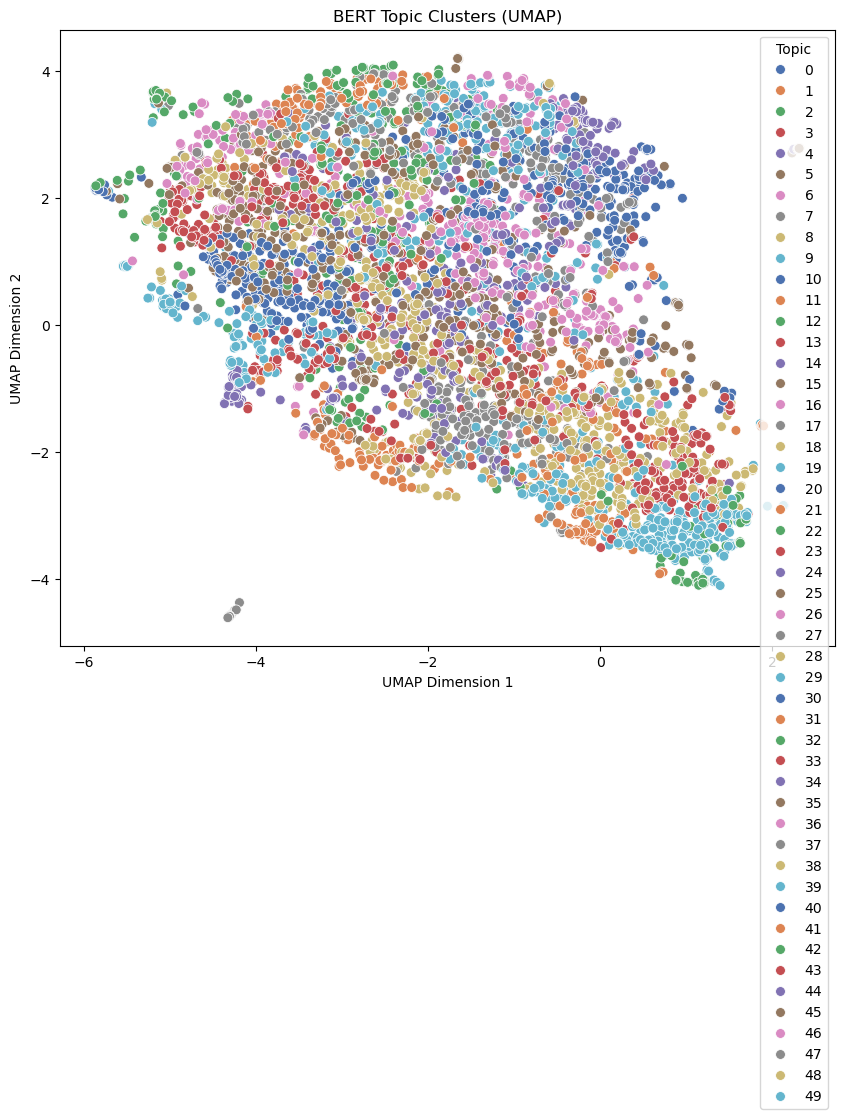

BERTopic modeling completed.


In [21]:
# Filter out empty documents
valid_docs = df['processed_text_bertopic'].str.len() > 0
texts = df.loc[valid_docs, 'processed_text_bertopic'].tolist()
valid_indices = df.index[valid_docs].tolist()

# Function to get BERT embeddings
def get_bert_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = bert_topic_modelling_tokenizer(batch_texts, return_tensors="pt", max_length=512, truncation=True, padding=True)
        with torch.no_grad():
            outputs = bert_topic_modelling_model(**inputs)
        # Use [CLS] token embedding or mean of token embeddings
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # [CLS] token
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings
print("Generating BERT embeddings...")
embeddings = get_bert_embeddings(texts)

# Cluster Embeddings to Identify Topics
kmeans = KMeans(n_clusters=num_topics, random_state=42)
topic_labels = kmeans.fit_predict(embeddings)
bert_topic_words = []
# Extract Representative Words for Each Topic
def get_topic_words(texts, labels, num_words=num_words):
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    doc_term_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    topic_words = []

    for topic_idx in range(num_topics):
        topic_docs = [i for i, label in enumerate(labels) if label == topic_idx]
        if not topic_docs:
            topic_words.append(f"Topic {topic_idx + 1}: (empty topic)")
            continue
        topic_doc_term = doc_term_matrix[topic_docs].sum(axis=0).A1
        top_word_indices = topic_doc_term.argsort()[-num_words:][::-1]
        wordlist = [feature_names[i] for i in top_word_indices]
        bert_topic_words.extend(wordlist)
        words = ", ".join(wordlist)
        topic_words.append(f"Topic {topic_idx + 1}: {words}")

    return topic_words

# Extract topic words
topic_report = get_topic_words(texts, topic_labels)

# Save topic report
with open("topic_modeling_report_bertopic_ao3.txt", "w") as f:
    f.write("BERTopic Modeling Results\n")
    f.write("=====================\n")
    for line in topic_report:
        f.write(line + "\n")

# Step 7: Assign Topics to Documents
dominant_topics = [None] * len(df)
for i, (idx, label) in enumerate(zip(valid_indices, topic_labels)):
    dominant_topics[idx] = label
df['dominant_topic_bert'] = dominant_topics
df.to_csv(output_filename, index=False, encoding='utf_8_sig')

# Step 8: Visualize Topics with UMAP
print("Generating topic visualization...")
umap_model = UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=topic_labels, palette='deep', s=50)
plt.title("BERT Topic Clusters (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Topic")
plt.savefig("bert_topic_visualization_ao3.png")
plt.show()
plt.close()

print("BERTopic modeling completed.")

#### Extract Top 50 words from Top 50 topics

In [ ]:
word_counts = Counter(bert_topic_words)

# Get the top 50 words by frequency
top_50_words = word_counts.most_common(50)

# Print or save the results
print("Top 50 Words Across All Topics:")
for rank, (word, score) in enumerate(top_50_words, 1):
    print(f"{rank:2}. {word:<15} {score}")

# Save to CSV (optional)
top_words_df = pd.DataFrame(top_50_words, columns=["Word", "Frequency"])
top_words_df.to_csv("top_50_words_from_bert_ao3.csv", index=False, encoding='utf_8_sig')

Top 50 Words Across All Topics:
 1. make            30
 2. time            30
 3. life            25
 4. love            24
 5. know            24
 6. story           20
 7. want            19
 8. come            17
 9. world           16
10. year            12
11. think           11
12. day             10
13. character       8
14. way             8
15. help            7
16. say             7
17. friend          6
18. work            6
19. try             6
20. girl            6
21. happen          5
22. write           5
23. decide          5
24. meet            5
25. hero            4
26. look            4
27. school          4
28. man             4
29. end             4
30. anime           4
31. feel            4
32. chapter         4
33. series          4
34. relationship    3
35. collection      3
36. request         3
37. oneshot         3
38. eye             3
39. manga           3
40. fall            3
41. power           3
42. ask             3
43. game            3
44. night 

### Topic Modelling - LDA

In [15]:
# Create Document-Term Matrix
# Filter out empty documents and keep track of valid indices
valid_docs_lda = df['processed_text_lda'].apply(lambda x: len(x) > 0 if x is not None else False)
processed_docs = df.loc[valid_docs_lda, 'processed_text_lda'].tolist()
valid_indices_lda = df.index[valid_docs_lda].tolist()

# Create dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create corpus (bag-of-words representation)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model
lda_model = LdaModel(corpus=corpus, # Create LDA model
                     id2word=dictionary, # Dictionary for the model
                     num_topics=num_topics, # Number of topics
                     random_state=42, # Random state for reproducibility
                     passes=10, # Number of passes through the corpus
                     alpha='auto', # Hyperparameter for document-topic density
                     eta='auto') # Hyperparameter for topic-word density

# Extract topics and their words
topics = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
topic_report = []
lda_topic_words = []
for idx, topic in enumerate(topics, start=1):
    topic_words_processed = [word.split("*")[1].strip('" ') for word in topic[1].split(" + ")]
    lda_topic_words.extend(topic_words_processed)
    topic_words = ", ".join(topic_words_processed)
    topic_report.append(f"Topic {idx}: {topic_words}")

# Get dominate topic
def get_dominant_topic(doc_bow):
    topic_dist = lda_model[doc_bow]
    if topic_dist:
        return max(topic_dist, key=lambda x: x[1])[0]
    return None

with open("topic_modeling_report_lda_ao3.txt", "w") as f:
    f.write("Topic Modeling Results\n")
    f.write("=====================\n")
    for line in topic_report:
        f.write(line + "\n")

dominant_topics = [None] * len(df)
for i, (idx, bow) in enumerate(zip(valid_indices_lda, corpus)):
    dominant_topics[idx] = get_dominant_topic(bow)

df['dominant_topic_lda'] = dominant_topics
df.to_csv(output_filename, index=False, encoding='utf_8_sig')

# Visualize Topics with pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, vis_output) # Save the visualization to an HTML file

In [16]:
df.to_csv(output_filename, index=False, encoding='utf_8_sig')

#### Extract Top 50 words from Top 50 topics

In [17]:
word_counts = Counter(lda_topic_words)

# Get the top 50 words by frequency
top_50_words = word_counts.most_common(50)

# Print or save the results
print("Top 50 Words Across All Topics:")
for rank, (word, score) in enumerate(top_50_words, 1):
    print(f"{rank:2}. {word:<15} {score}")

# Save to CSV (optional)
top_words_df = pd.DataFrame(top_50_words, columns=["Word", "Frequency"])
top_words_df.to_csv("top_50_words_from_lda.csv", index=False, encoding='utf_8_sig')

Top 50 Words Across All Topics:
 1. find            11
 2. get             8
 3. know            7
 4. time            7
 5. love            5
 6. world           5
 7. character       5
 8. take            4
 9. make            4
10. see             4
11. life            3
12. day             3
13. girl            3
14. man             3
15. look            3
16. year            3
17. come            3
18. relationship    3
19. way             2
20. meet            2
21. death           2
22. series          2
23. adventure       2
24. write           2
25. want            2
26. ask             2
27. eye             2
28. say             2
29. wake            2
30. chapter         2
31. collection      2
32. open            2
33. read            2
34. end             2
35. name            2
36. show            2
37. boy             2
38. hero            2
39. anime           2
40. night           2
41. akira           2
42. contain         1
43. humanity        1
44. killer          1

### Sentiment analysis

In [ ]:
# text = "The story was amazing and emotional!"
# result = sentiment_pipeline(text)[0]
# label = label_map[result['label']]
# score = result['score']
# print(f"Sentiment: {label}, Score: {score:.3f}")

In [18]:
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series([None, None])
    result = sentiment_pipeline(text)[0]
    return pd.Series([label_map[result['label']], result['score']])

# Add sentiment results to DataFrame
df[['sentiment_label', 'sentiment_score']] = df['Translated Summary'].apply(get_sentiment)

In [23]:
df.to_csv(output_filename, index=False, encoding='utf_8_sig')

In [20]:
word_counts = Counter(lda_topic_words)

# Get the top 50 words by frequency
top_50_words = word_counts.most_common(50)

# Print or save the results
print("Top 50 Words Across All Topics:")
for rank, (word, score) in enumerate(top_50_words, 1):
    print(f"{rank:2}. {word:<15} {score}")

Top 50 Words Across All Topics:
 1. find            11
 2. get             8
 3. know            7
 4. time            7
 5. love            5
 6. world           5
 7. character       5
 8. take            4
 9. make            4
10. see             4
11. life            3
12. day             3
13. girl            3
14. man             3
15. look            3
16. year            3
17. come            3
18. relationship    3
19. way             2
20. meet            2
21. death           2
22. series          2
23. adventure       2
24. write           2
25. want            2
26. ask             2
27. eye             2
28. say             2
29. wake            2
30. chapter         2
31. collection      2
32. open            2
33. read            2
34. end             2
35. name            2
36. show            2
37. boy             2
38. hero            2
39. anime           2
40. night           2
41. akira           2
42. contain         1
43. humanity        1
44. killer          1